<a href="https://colab.research.google.com/github/RyanChen12035/capstone/blob/main/evaluation_v5_precisionatK_newblacklist_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.0 --quiet
!pip install transformers==4.15.0 --quiet
!pip install faiss-gpu transformers torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 27.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


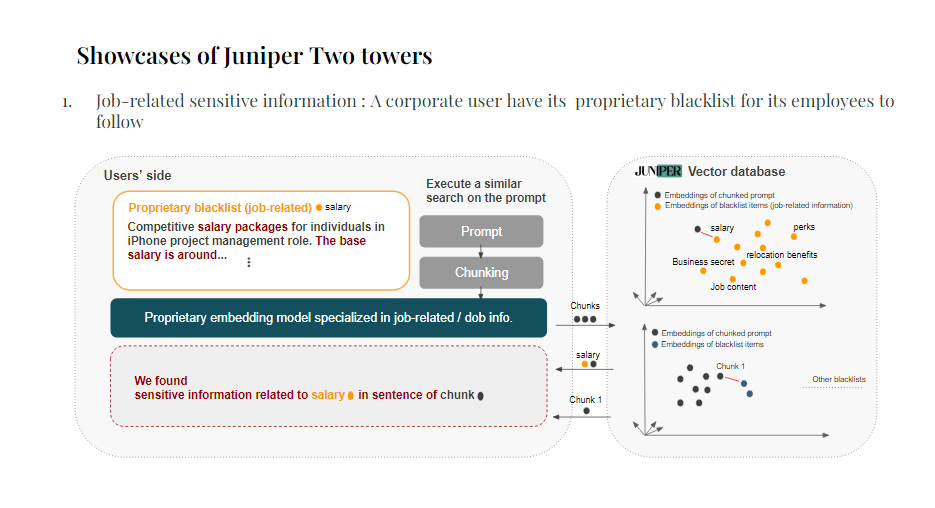

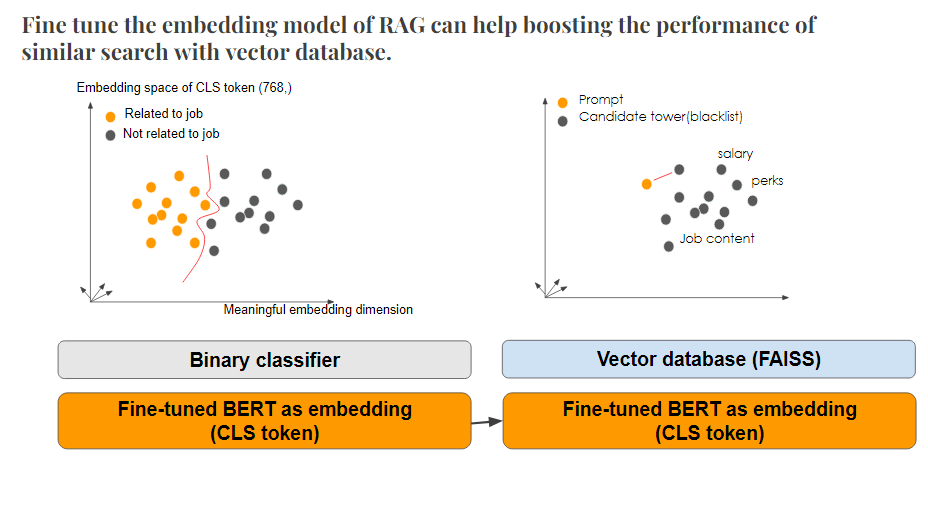

Evaluation of V5 BERT model as the embedding base model of vector database and treat it as an evaluation for recomendation system.

Suppose that precision at 10 in a top-10 recommendation problem is 80%. This means that 80% of the recommendation I make are relevant to the user.

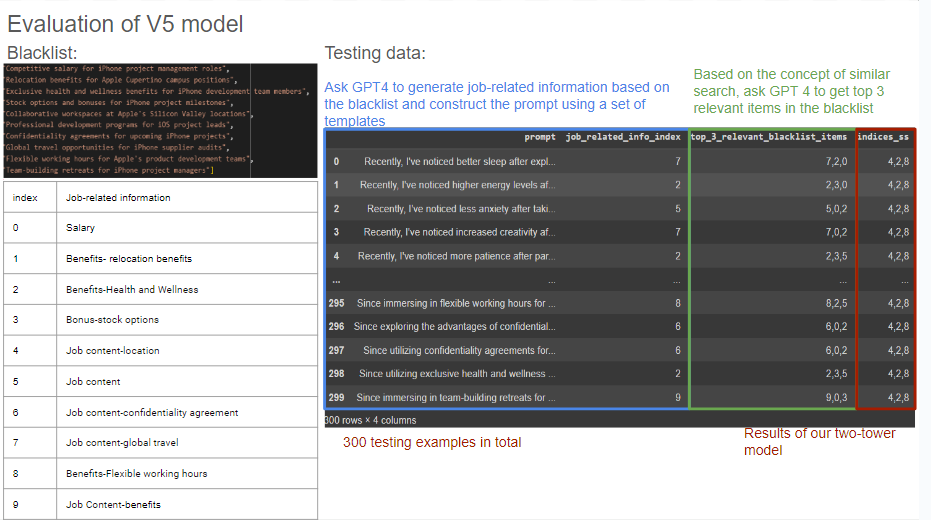

Job related information as a product engineer at Apple


In [ ]:
level_four_job = ["Competitive salary for iPhone project management roles",
                  "Relocation benefits for Apple Cupertino campus positions",
                  "Exclusive health and wellness benefits for iPhone development team members",
                  "Stock options and bonuses for iPhone project milestones",
                  "Collaborative workspaces at Apple's Silicon Valley locations",
                  "Professional development programs for iOS project leads",
                  "Confidentiality agreements for upcoming iPhone projects",
                  "Global travel opportunities for iPhone supplier audits",
                  "Flexible working hours for Apple's product development teams",
                  "Team-building retreats for iPhone project managers"]

Suppose that precision at 10 in a top-10 recommendation problem is 80%. This means that 80% of the recommendation I make are relevant to the user.

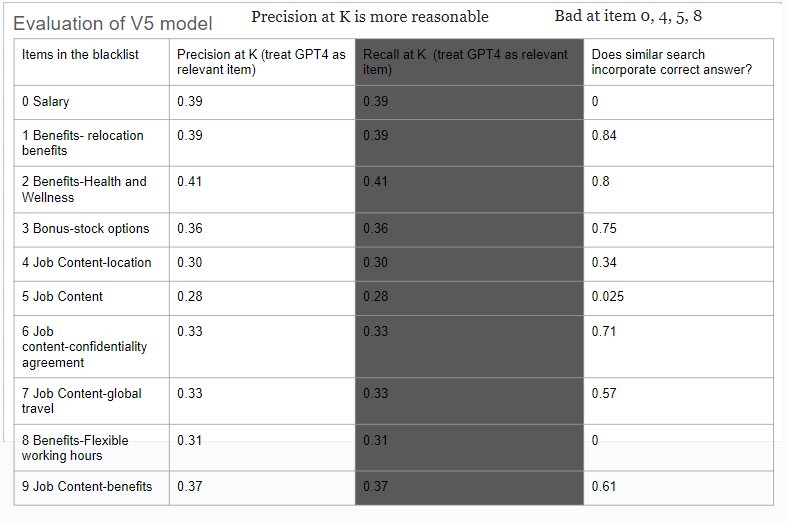

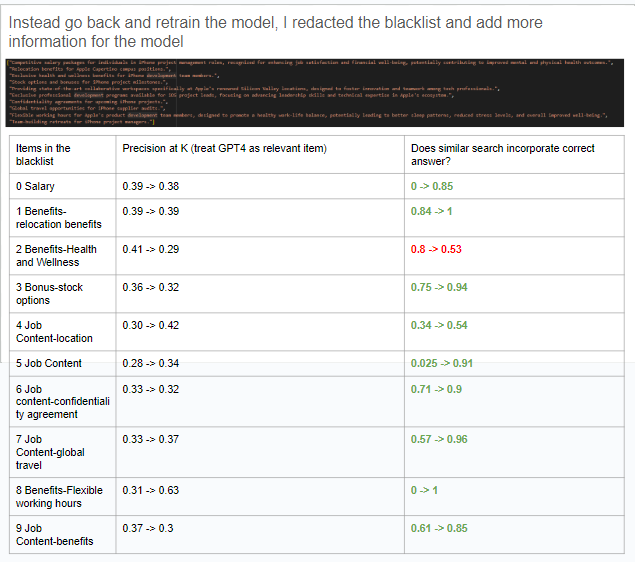

In [ ]:
level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits tailored for iPhone development team members, encompassing comprehensive medical insurance, mental health support services, and access to fitness facilities. These benefits are designed to ensure the physical and mental well-being of our team, contributing to a supportive and healthy work environment.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces at Apple's renowned Silicon Valley locations, equipped with the latest technology and ergonomic designs. These spaces are created to enhance productivity, foster innovation, and facilitate seamless teamwork among tech professionals. The environment promotes not only professional growth but also mental well-being through a supportive and interactive setting.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers."]

In [ ]:
from tensorflow.keras.models import load_model
custom_objects = {'TFBertModel': TFBertModel}
model_v5data = load_model('./drive/MyDrive/two_tower_bert_v5.h5', custom_objects=custom_objects)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import numpy as np
# cls extraction
def generate_embedding_cls(text, model):
  bert_embedding_model = Model(inputs=[model.input],
                               outputs=model.get_layer('tf.__operators__.getitem').output)
  bert_train_tokenized = bert_tokenizer(text,
                                        max_length=128,
                                        truncation=True,
                                        padding='max_length',
                                        return_tensors='tf')
  bert_train_inputs = [bert_train_tokenized.input_ids,
                       bert_train_tokenized.token_type_ids,
                       bert_train_tokenized.attention_mask]
  return bert_embedding_model.predict(bert_train_inputs)


def embedding_vectordatabase(embedding):
  embeddings = np.array(embedding, dtype="float32")
  embeddings = embeddings.reshape(-1, embeddings.shape[-1])
  return embeddings

In [ ]:
# create vector databases
import faiss
import numpy as np

dimension = 768  # Dimension of BERT-base embeddings
index_cls_v5 = faiss.IndexFlatL2(dimension)

In [ ]:
# bad at 0, 4, 5, 8, rewrote it

level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
                  "Relocation benefits for Apple Cupertino campus positions.",
                  "Exclusive health and wellness benefits tailored for iPhone development team members, encompassing comprehensive medical insurance, mental health support services, and access to fitness facilities. These benefits are designed to ensure the physical and mental well-being of our team, contributing to a supportive and healthy work environment.",
                  "Stock options and bonuses for iPhone project milestones.",
                  "Providing state-of-the-art collaborative workspaces at Apple's renowned Silicon Valley locations, equipped with the latest technology and ergonomic designs. These spaces are created to enhance productivity, foster innovation, and facilitate seamless teamwork among tech professionals. The environment promotes not only professional growth but also mental well-being through a supportive and interactive setting.",
                  "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
                  "Confidentiality agreements for upcoming iPhone projects.",
                  "Global travel opportunities for iPhone supplier audits.",
                  "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
                  "Team-building retreats for iPhone project managers."]

for input in level_four_job:
  embeddings = generate_embedding_cls(input, model_v5data)
  index_cls_v5.add(embedding_vectordatabase(embeddings))
print(index_cls_v5.ntotal)

10


In [ ]:
# more specific and concret blacklist but use the original test data (generated by used blacklist)

In [ ]:
df_GPT_evaluation =  pd.read_csv("./drive/MyDrive/job_related_GPT_evaluation_updated.csv", error_bad_lines=False)
df_GPT_evaluation

<ipython-input-71-415d5b7f7990>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_GPT_evaluation =  pd.read_csv("./drive/MyDrive/job_related_GPT_evaluation_updated.csv", error_bad_lines=False)


,prompt,job_related_info_index,top_3_relevant_blacklist_items
0,"Recently, I've noticed better sleep after expl...",7,"7,2,0"
1,"Recently, I've noticed higher energy levels af...",2,"2,3,0"
2,"Recently, I've noticed less anxiety after taki...",5,"5,0,2"
3,"Recently, I've noticed increased creativity af...",7,"7,0,2"
4,"Recently, I've noticed more patience after par...",2,"2,3,5"
...,...,...,...
295,Since immersing in flexible working hours for ...,8,"8,2,5"
296,Since exploring the advantages of confidential...,6,"6,0,2"
297,Since utilizing confidentiality agreements for...,6,"6,0,2"
298,Since utilizing exclusive health and wellness ...,2,"2,3,5"


In [ ]:
k = 3
indices_ss = []
distance_ss = []
for prompt in df_GPT_evaluation['prompt']:
    embeddings_v5 = generate_embedding_cls(prompt, model_v5data)
    distances_v5, indices_v5 = index_cls_v5.search(embeddings_v5, k)
    indices_ss.append(indices_v5)
    # distance_ss.append(distance_ss)

In [ ]:
indices_ss_series = pd.Series(indices_ss)
# distance_ss_series = pd.Series(distance_ss)
df_GPT_evaluation_sechalf = df_GPT_evaluation.iloc[:300]
df_GPT_evaluation_sechalf.reset_index(drop=True, inplace=True)
df_GPT_evaluation_sechalf['indices_ss'] = indices_ss_series
# df_GPT_evaluation_sechalf['distance_ss'] = distance_ss_series

<ipython-input-73-29fc158174f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GPT_evaluation_sechalf['indices_ss'] = indices_ss_series


In [ ]:
df_GPT_evaluation_sechalf.to_csv('./drive/MyDrive/job_related_GPT_evaluation_v5_ss_newblacklist_1.csv', index=False)

In [ ]:
df_GPT_evaluation_sechalf

,prompt,job_related_info_index,top_3_relevant_blacklist_items,indices_ss
0,"Recently, I've noticed better sleep after expl...",7,"7,2,0","[[2, 8, 3]]"
1,"Recently, I've noticed higher energy levels af...",2,"2,3,0","[[2, 8, 3]]"
2,"Recently, I've noticed less anxiety after taki...",5,"5,0,2","[[4, 2, 8]]"
3,"Recently, I've noticed increased creativity af...",7,"7,0,2","[[7, 8, 5]]"
4,"Recently, I've noticed more patience after par...",2,"2,3,5","[[2, 8, 5]]"
...,...,...,...,...
295,Since immersing in flexible working hours for ...,8,"8,2,5","[[8, 5, 9]]"
296,Since exploring the advantages of confidential...,6,"6,0,2","[[4, 1, 6]]"
297,Since utilizing confidentiality agreements for...,6,"6,0,2","[[3, 6, 7]]"
298,Since utilizing exclusive health and wellness ...,2,"2,3,5","[[2, 8, 4]]"


In [ ]:
# precision and recall at K
# if top 3 contains the correct one?

df_first_half =  pd.read_csv("./drive/MyDrive/job_related_GPT_evaluation_v5_ss_newblacklist_1.csv", error_bad_lines=False)
# df_second_half =  pd.read_csv("./drive/MyDrive/job_related_GPT_evaluation_v5_ss.csv", error_bad_lines=False)
# df_GPT_evaluation = pd.concat([df_first_half, df_second_half])
df_GPT_evaluation = df_first_half

<ipython-input-76-70dbeb59970e>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_first_half =  pd.read_csv("./drive/MyDrive/job_related_GPT_evaluation_v5_ss_newblacklist_1.csv", error_bad_lines=False)


In [ ]:
df_GPT_evaluation['indices_ss'] = df_GPT_evaluation['indices_ss'].apply(lambda x: ','.join(map(str, np.fromstring(x.strip('[]'), dtype=int, sep=' '))))

In [ ]:
df_GPT_evaluation

,prompt,job_related_info_index,top_3_relevant_blacklist_items,indices_ss
0,"Recently, I've noticed better sleep after expl...",7,"7,2,0","2,8,3"
1,"Recently, I've noticed higher energy levels af...",2,"2,3,0","2,8,3"
2,"Recently, I've noticed less anxiety after taki...",5,"5,0,2","4,2,8"
3,"Recently, I've noticed increased creativity af...",7,"7,0,2","7,8,5"
4,"Recently, I've noticed more patience after par...",2,"2,3,5","2,8,5"
...,...,...,...,...
295,Since immersing in flexible working hours for ...,8,"8,2,5","8,5,9"
296,Since exploring the advantages of confidential...,6,"6,0,2","4,1,6"
297,Since utilizing confidentiality agreements for...,6,"6,0,2","3,6,7"
298,Since utilizing exclusive health and wellness ...,2,"2,3,5","2,8,4"


In [ ]:
def calculate_precision_recall_at_k(relevant_items, recommended_items, k=3):
    relevant_set = set(relevant_items.split(','))
    recommended_set = set(recommended_items.split(','))
    relevant_and_recommended = recommended_set.intersection(relevant_set)
    precision = len(relevant_and_recommended) / k
    recall = len(relevant_and_recommended) / len(relevant_set)
    return precision, recall

df_GPT_evaluation['precision@3'], df_GPT_evaluation['recall@3'] = zip(*df_GPT_evaluation.apply(lambda x: calculate_precision_recall_at_k(x['top_3_relevant_blacklist_items'], x['indices_ss']), axis=1))

In [ ]:
def check_correctness(relevant_items, recommended_items, job_related_info_index):
    relevant_correct = str(job_related_info_index) in relevant_items.split(',')
    recommended_correct = str(job_related_info_index) in recommended_items.split(',')
    return relevant_correct, recommended_correct

df_GPT_evaluation['GPT_correct'], df_GPT_evaluation['twotower_correct'] = zip(*df_GPT_evaluation.apply(lambda x: check_correctness(x['top_3_relevant_blacklist_items'], x['indices_ss'], x['job_related_info_index']), axis=1))

In [ ]:
df_GPT_evaluation

,prompt,job_related_info_index,top_3_relevant_blacklist_items,indices_ss,precision@3,recall@3,GPT_correct,twotower_correct
0,"Recently, I've noticed better sleep after expl...",7,"7,2,0","2,8,3",0.333333,0.333333,True,False
1,"Recently, I've noticed higher energy levels af...",2,"2,3,0","2,8,3",0.666667,0.666667,True,True
2,"Recently, I've noticed less anxiety after taki...",5,"5,0,2","4,2,8",0.333333,0.333333,True,False
3,"Recently, I've noticed increased creativity af...",7,"7,0,2","7,8,5",0.333333,0.333333,True,True
4,"Recently, I've noticed more patience after par...",2,"2,3,5","2,8,5",0.666667,0.666667,True,True
...,...,...,...,...,...,...,...,...
295,Since immersing in flexible working hours for ...,8,"8,2,5","8,5,9",0.666667,0.666667,True,True
296,Since exploring the advantages of confidential...,6,"6,0,2","4,1,6",0.333333,0.333333,True,True
297,Since utilizing confidentiality agreements for...,6,"6,0,2","3,6,7",0.333333,0.333333,True,True
298,Since utilizing exclusive health and wellness ...,2,"2,3,5","2,8,4",0.333333,0.333333,True,True


In [ ]:
# accuracy by index:

accuracy_by_index = df_GPT_evaluation.groupby('job_related_info_index')[['GPT_correct', 'twotower_correct']].mean()
average_precision = df_GPT_evaluation.groupby('job_related_info_index')['precision@3'].mean()
average_recall = df_GPT_evaluation.groupby('job_related_info_index')['recall@3'].mean()

print(accuracy_by_index, average_precision, average_recall)

                        GPT_correct  twotower_correct
job_related_info_index                               
0                               1.0          0.296296
1                               1.0          1.000000
2                               1.0          1.000000
3                               1.0          0.914286
4                               1.0          1.000000
5                               1.0          0.571429
6                               1.0          0.757576
7                               1.0          0.925926
8                               1.0          1.000000
9                               1.0          0.619048 job_related_info_index
0    0.197531
1    0.576923
2    0.406250
3    0.495238
4    0.575758
5    0.361905
6    0.464646
7    0.432099
8    0.682540
9    0.285714
Name: precision@3, dtype: float64 job_related_info_index
0    0.197531
1    0.576923
2    0.406250
3    0.495238
4    0.575758
5    0.361905
6    0.464646
7    0.432099
8    0.682540
9    0

In [ ]:
# orginal evaluation
#  GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.000000
# 1                               1.0          0.846154
# 2                               1.0          0.800000
# 3                               1.0          0.750000
# 4                               1.0          0.346154
# 5                               1.0          0.025000
# 6                               1.0          0.714286
# 7                               1.0          0.571429
# 8                               1.0          0.000000
# 9                               1.0          0.619048 job_related_info_index
# 0    0.393939
# 1    0.397436
# 2    0.411111
# 3    0.361111
# 4    0.307692
# 5    0.283333
# 6    0.333333
# 7    0.333333
# 8    0.318182
# 9    0.373016
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.393939
# 1    0.397436
# 2    0.411111
# 3    0.361111
# 4    0.307692
# 5    0.283333
# 6    0.333333
# 7    0.333333
# 8    0.318182
# 9    0.373016
# Name: recall@3, dtype: float64



# With a more lengthy and clear blacklist
#                         GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.185185
# 1                               1.0          1.000000
# 2                               1.0          1.000000
# 3                               1.0          0.028571
# 4                               1.0          0.000000
# 5                               1.0          0.000000
# 6                               1.0          0.939394
# 7                               1.0          0.000000
# 8                               1.0          0.000000
# 9                               1.0          0.880952 job_related_info_index
# 0    0.148148
# 1    0.666667
# 2    0.416667
# 3    0.409524
# 4    0.287879
# 5    0.342857
# 6    0.717172
# 7    0.469136
# 8    0.349206
# 9    0.396825
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.148148
# 1    0.666667
# 2    0.416667
# 3    0.409524
# 4    0.287879
# 5    0.342857
# 6    0.717172
# 7    0.469136
# 8    0.349206
# 9    0.396825
# Name: recall@3, dtype: float64

# rewrite only  0, 4, 5, 8 keep the wording but more specific
# GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.000000
# 1                               1.0          1.000000
# 2                               1.0          0.937500
# 3                               1.0          0.942857
# 4                               1.0          0.590909
# 5                               1.0          0.000000
# 6                               1.0          0.848485
# 7                               1.0          1.000000
# 8                               1.0          0.095238
# 9                               1.0          0.833333 job_related_info_index
# 0    0.493827
# 1    0.423077
# 2    0.427083
# 3    0.419048
# 4    0.378788
# 5    0.219048
# 6    0.323232
# 7    0.432099
# 8    0.333333
# 9    0.404762
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.493827
# 1    0.423077
# 2    0.427083
# 3    0.419048
# 4    0.378788
# 5    0.219048
# 6    0.323232
# 7    0.432099
# 8    0.333333
# 9    0.404762
# Name: recall@3, dtype: float64

# no4 got improved, and overall got improved as well. Rewrite it again
# level_four_job = ["Offering competitive salary packages for specialists in iPhone project management roles, reflective of the industry standards and job demands.",
#                   "Relocation benefits for Apple Cupertino campus positions.",
#                   "Exclusive health and wellness benefits for iPhone development team members.",
#                   "Stock options and bonuses for iPhone project milestones.",
#                   "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
#                   "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
#                   "Confidentiality agreements for upcoming iPhone projects.",
#                   "Global travel opportunities for iPhone supplier audits.",
#                   "Implementing flexible working hours for Apple's product development teams to support work-life balance and enhance productivity in developing cutting-edge technologies.",
#                   "Team-building retreats for iPhone project managers."]
# GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.000000
# 1                               1.0          1.000000
# 2                               1.0          0.906250
# 3                               1.0          0.942857
# 4                               1.0          0.863636
# 5                               1.0          0.971429
# 6                               1.0          0.787879
# 7                               1.0          1.000000
# 8                               1.0          0.000000
# 9                               1.0          0.785714 job_related_info_index
# 0    0.382716
# 1    0.410256
# 2    0.447917
# 3    0.400000
# 4    0.454545
# 5    0.485714
# 6    0.303030
# 7    0.395062
# 8    0.492063
# 9    0.357143
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.382716
# 1    0.410256
# 2    0.447917
# 3    0.400000
# 4    0.454545
# 5    0.485714
# 6    0.303030
# 7    0.395062
# 8    0.492063
# 9    0.357143
# Name: recall@3, dtype: float64

#no 0 and 8 still remain awful, try to redact 0 and 8 only
# level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
#                   "Relocation benefits for Apple Cupertino campus positions.",
#                   "Exclusive health and wellness benefits for iPhone development team members.",
#                   "Stock options and bonuses for iPhone project milestones.",
#                   "Providing state-of-the-art collaborative workspaces specifically at Apple's renowned Silicon Valley locations, designed to foster innovation and teamwork among tech professionals.",
#                   "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
#                   "Confidentiality agreements for upcoming iPhone projects.",
#                   "Global travel opportunities for iPhone supplier audits.",
#                   "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
#                   "Team-building retreats for iPhone project managers."]

#  GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.851852
# 1                               1.0          1.000000
# 2                               1.0          0.531250
# 3                               1.0          0.942857
# 4                               1.0          0.545455
# 5                               1.0          0.914286
# 6                               1.0          0.909091
# 7                               1.0          0.962963
# 8                               1.0          1.000000
# 9                               1.0          0.857143 job_related_info_index
# 0    0.382716
# 1    0.384615
# 2    0.291667
# 3    0.323810
# 4    0.424242
# 5    0.342857
# 6    0.323232
# 7    0.370370
# 8    0.634921
# 9    0.309524
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.382716
# 1    0.384615
# 2    0.291667
# 3    0.323810
# 4    0.424242
# 5    0.342857
# 6    0.323232
# 7    0.370370
# 8    0.634921
# 9    0.309524

#elaborate item 2 and 4 a bit more
# level_four_job = ["Competitive salary packages for individuals in iPhone project management roles, recognized for enhancing job satisfaction and financial well-being, potentially contributing to improved mental and physical health outcomes.",
#                   "Relocation benefits for Apple Cupertino campus positions.",
#                   "Exclusive health and wellness benefits tailored for iPhone development team members, encompassing comprehensive medical insurance, mental health support services, and access to fitness facilities. These benefits are designed to ensure the physical and mental well-being of our team, contributing to a supportive and healthy work environment.",
#                   "Stock options and bonuses for iPhone project milestones.",
#                   "Providing state-of-the-art collaborative workspaces at Apple's renowned Silicon Valley locations, equipped with the latest technology and ergonomic designs. These spaces are created to enhance productivity, foster innovation, and facilitate seamless teamwork among tech professionals. The environment promotes not only professional growth but also mental well-being through a supportive and interactive setting.",
#                   "Exclusive professional development programs available for iOS project leads, focusing on advancing leadership skills and technical expertise in Apple's ecosystem.",
#                   "Confidentiality agreements for upcoming iPhone projects.",
#                   "Global travel opportunities for iPhone supplier audits.",
#                   "Flexible working hours for Apple's product development team members, designed to promote a healthy work-life balance, potentially leading to better sleep patterns, reduced stress levels, and overall improved well-being.",
#                   "Team-building retreats for iPhone project managers."]
                        # GPT_correct  twotower_correct
# job_related_info_index
# 0                               1.0          0.296296
# 1                               1.0          1.000000
# 2                               1.0          1.000000
# 3                               1.0          0.914286
# 4                               1.0          1.000000
# 5                               1.0          0.571429
# 6                               1.0          0.757576
# 7                               1.0          0.925926
# 8                               1.0          1.000000
# 9                               1.0          0.619048 job_related_info_index
# 0    0.197531
# 1    0.576923
# 2    0.406250
# 3    0.495238
# 4    0.575758
# 5    0.361905
# 6    0.464646
# 7    0.432099
# 8    0.682540
# 9    0.285714
# Name: precision@3, dtype: float64 job_related_info_index
# 0    0.197531
# 1    0.576923
# 2    0.406250
# 3    0.495238
# 4    0.575758
# 5    0.361905
# 6    0.464646
# 7    0.432099
# 8    0.682540
# 9    0.285714
# Name: recall@3, dtype: float64

# 0,5 and 2,4 seem like competing with each other. both 0 and 2 are talked about salary and benefits. Both 4,5 talked about personal growth

